In this example, we will compare effectiveness of stop loss and trailing stop orders across multiple stocks. 

First, we will pick top cryptocurrencies by market cap. For each one, we will roll a fixed time window over the entire history and select the first date of each window as a buy signal. For each such signal, we will place 1) a stop loss order and 2) trailing stop order. These will be our exit signals stored in separate variables. We will also place 3) random exit signals in our third variable to be able to compare effectiveness of stop loss with that of random shorting. Finally, we will calculate and compare the performance of each strategy. Thanks to vectorbt, millions of such tests can be done in a matter of minutes.

In [1]:
import vectorbt as vbt

In [2]:
import numpy as np
import pandas as pd
import itertools
import yfinance as yf
from datetime import datetime, timedelta
from numba import njit, f8, i8, b1, optional
import ipywidgets

In [3]:
# Define your params here
seed = 42
asset_names = [
    'BTC-USD', 'ETH-USD', 'XRP-USD', 'BCH-USD', 'LTC-USD', 
    'BNB-USD', 'EOS-USD', 'XLM-USD', 'XMR-USD', 'ADA-USD']
price_name = 'Open'

history_len = timedelta(days=365*2)
end_date = datetime.now()
start_date = end_date - history_len
time_window = timedelta(days=365) # length of a time window

stops = np.arange(0, 1, 0.01) # in %

investment = 100 # in $
commission = 0.0025 # in %
slippage = 0.0025 # in %

print(len(asset_names) * (history_len.days - time_window.days), 'experiments per stop value')
print(len(stops), 'stop values per stop type')
print(len(asset_names) * (history_len.days - time_window.days) * len(stops), 'experiments per stop type')

3650 experiments per stop value
100 stop values per stop type
365000 experiments per stop type


In [4]:
%%time
# Download data
ohlcv_cols = ['Open', 'High', 'Low', 'Close', 'Volume']
asset_history = {k: yf.Ticker(k).history(start=start_date, end=end_date) for k in asset_names}
asset_history = {k: v[ohlcv_cols] for k, v in asset_history.items()}
asset_history = {k: v.astype(np.float64) for k, v in asset_history.items()}

for k, v in asset_history.items():
    print(k, v.shape)
    
print(asset_history['BTC-USD'].columns)

BTC-USD (730, 5)
ETH-USD (730, 5)
XRP-USD (730, 5)
BCH-USD (730, 5)
LTC-USD (730, 5)
BNB-USD (730, 5)
EOS-USD (730, 5)
XLM-USD (730, 5)
XMR-USD (730, 5)
ADA-USD (730, 5)
Index(['Open', 'High', 'Low', 'Close', 'Volume'], dtype='object')
CPU times: user 773 ms, sys: 44.9 ms, total: 818 ms
Wall time: 2.93 s


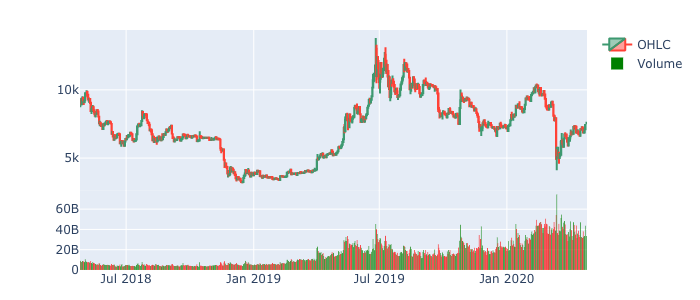

In [5]:
asset_history['BTC-USD'].vbt.ohlcv.plot().show_png()

In [6]:
%%time
# Stack all dfs along each column
price = pd.concat(map(lambda x: x[price_name], asset_history.values()), axis=1)
price.columns = pd.Index(asset_history.keys(), name='asset_name')

print(price.shape)
print(price.columns) # number of stocks

(730, 10)
Index(['BTC-USD', 'ETH-USD', 'XRP-USD', 'BCH-USD', 'LTC-USD', 'BNB-USD',
       'EOS-USD', 'XLM-USD', 'XMR-USD', 'ADA-USD'],
      dtype='object', name='asset_name')
CPU times: user 5.6 ms, sys: 1.72 ms, total: 7.32 ms
Wall time: 7.83 ms


In [7]:
%%time
# Split the whole time period into time ranges
price = price.vbt.timeseries.rolling_window(time_window.days)
    
print(price.shape)
print(price.columns) # number of stocks x number of ranges

(365, 3660)
MultiIndex([('2018-04-26', 'BTC-USD'),
            ('2018-04-26', 'ETH-USD'),
            ('2018-04-26', 'XRP-USD'),
            ('2018-04-26', 'BCH-USD'),
            ('2018-04-26', 'LTC-USD'),
            ('2018-04-26', 'BNB-USD'),
            ('2018-04-26', 'EOS-USD'),
            ('2018-04-26', 'XLM-USD'),
            ('2018-04-26', 'XMR-USD'),
            ('2018-04-26', 'ADA-USD'),
            ...
            ('2019-04-26', 'BTC-USD'),
            ('2019-04-26', 'ETH-USD'),
            ('2019-04-26', 'XRP-USD'),
            ('2019-04-26', 'BCH-USD'),
            ('2019-04-26', 'LTC-USD'),
            ('2019-04-26', 'BNB-USD'),
            ('2019-04-26', 'EOS-USD'),
            ('2019-04-26', 'XLM-USD'),
            ('2019-04-26', 'XMR-USD'),
            ('2019-04-26', 'ADA-USD')],
           names=['start_date', 'asset_name'], length=3660)
CPU times: user 27.2 ms, sys: 13.8 ms, total: 41 ms
Wall time: 47.4 ms


In [8]:
%%time
# Pick 1 signal at the beginning of each time range
entries = pd.DataFrame.vbt.signals.empty(price.shape)
entries.iloc[0, :] = True

# Right now our rand signals have no meaningful columns
entries.columns = price.columns

print(entries.shape)
print(entries.columns)

(365, 3660)
MultiIndex([('2018-04-26', 'BTC-USD'),
            ('2018-04-26', 'ETH-USD'),
            ('2018-04-26', 'XRP-USD'),
            ('2018-04-26', 'BCH-USD'),
            ('2018-04-26', 'LTC-USD'),
            ('2018-04-26', 'BNB-USD'),
            ('2018-04-26', 'EOS-USD'),
            ('2018-04-26', 'XLM-USD'),
            ('2018-04-26', 'XMR-USD'),
            ('2018-04-26', 'ADA-USD'),
            ...
            ('2019-04-26', 'BTC-USD'),
            ('2019-04-26', 'ETH-USD'),
            ('2019-04-26', 'XRP-USD'),
            ('2019-04-26', 'BCH-USD'),
            ('2019-04-26', 'LTC-USD'),
            ('2019-04-26', 'BNB-USD'),
            ('2019-04-26', 'EOS-USD'),
            ('2019-04-26', 'XLM-USD'),
            ('2019-04-26', 'XMR-USD'),
            ('2019-04-26', 'ADA-USD')],
           names=['start_date', 'asset_name'], length=3660)
CPU times: user 32.1 ms, sys: 3.4 ms, total: 35.5 ms
Wall time: 35.7 ms


In [9]:
%%time
# Calculate stop loss exits
stop_loss_exits = entries.vbt.signals.stop_loss_exits(price, stops)
trail_stop_exits = entries.vbt.signals.stop_loss_exits(price, stops, trailing=True)

print(stop_loss_exits.shape, trail_stop_exits.shape)
print(stop_loss_exits.columns)

# Update columns to match those of stop exits
entries = entries.vbt.tile(len(stops))
price = price.vbt.tile(len(stops))

assert(stop_loss_exits.shape == entries.shape)
assert(stop_loss_exits.shape == price.shape)

(365, 366000) (365, 366000)
MultiIndex([( 0.0, '2018-04-26', 'BTC-USD'),
            ( 0.0, '2018-04-26', 'ETH-USD'),
            ( 0.0, '2018-04-26', 'XRP-USD'),
            ( 0.0, '2018-04-26', 'BCH-USD'),
            ( 0.0, '2018-04-26', 'LTC-USD'),
            ( 0.0, '2018-04-26', 'BNB-USD'),
            ( 0.0, '2018-04-26', 'EOS-USD'),
            ( 0.0, '2018-04-26', 'XLM-USD'),
            ( 0.0, '2018-04-26', 'XMR-USD'),
            ( 0.0, '2018-04-26', 'ADA-USD'),
            ...
            (0.99, '2019-04-26', 'BTC-USD'),
            (0.99, '2019-04-26', 'ETH-USD'),
            (0.99, '2019-04-26', 'XRP-USD'),
            (0.99, '2019-04-26', 'BCH-USD'),
            (0.99, '2019-04-26', 'LTC-USD'),
            (0.99, '2019-04-26', 'BNB-USD'),
            (0.99, '2019-04-26', 'EOS-USD'),
            (0.99, '2019-04-26', 'XLM-USD'),
            (0.99, '2019-04-26', 'XMR-USD'),
            (0.99, '2019-04-26', 'ADA-USD')],
           names=['stop_loss', 'start_date', 'asset_nam

In [10]:
# How many stop exits for each entry on average?
print(stop_loss_exits.vbt.signals.num_signals.mean())
print(trail_stop_exits.vbt.signals.num_signals.mean())

0.515172131147541
0.7009863387978142


In [11]:
%%time
# To compare our stop loss orders with random trading strategy we need to place random exits
# After each entry signal place exactly one exit signal randomly
rand_exits = entries.vbt.signals.random_exits(1, seed=seed)

assert(entries.shape == rand_exits.shape)

CPU times: user 939 ms, sys: 48.6 ms, total: 988 ms
Wall time: 990 ms


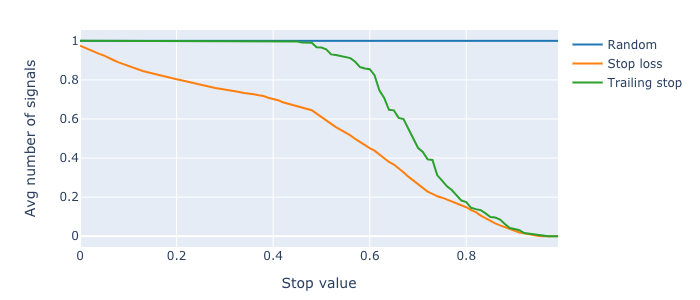

CPU times: user 456 ms, sys: 35.4 ms, total: 492 ms
Wall time: 602 ms


In [12]:
%%time
# How many exit signals our orders have generated?
stop_cols = stop_loss_exits.columns.get_level_values('stop_loss')

pd.DataFrame({
    'Random': rand_exits.vbt.signals.num_signals.groupby(stop_cols).mean(),
    'Stop loss': stop_loss_exits.vbt.signals.num_signals.groupby(stop_cols).mean(),
    'Trailing stop': trail_stop_exits.vbt.signals.num_signals.groupby(stop_cols).mean()
}).vbt.Scatter(xaxis_title='Stop value', yaxis_title='Avg number of signals').show_png()

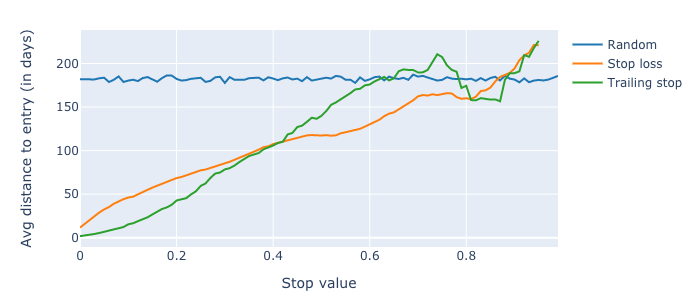

CPU times: user 8.11 s, sys: 260 ms, total: 8.37 s
Wall time: 8.66 s


In [13]:
%%time
# And what is the average distance to the entry signal?
@njit
def map_func_nb(col, entry_i, exit_i):
    return exit_i - entry_i # distance

@njit
def reduce_func_nb(a):
    return np.nanmean(a) # average of all distances

pd.DataFrame({
    'Random': entries.vbt.signals.map_reduce_between(
        other=rand_exits, 
        map_func_nb=map_func_nb, 
        reduce_func_nb=reduce_func_nb).groupby(stop_cols).mean(),
    'Stop loss': entries.vbt.signals.map_reduce_between(
        other=stop_loss_exits, 
        map_func_nb=map_func_nb, 
        reduce_func_nb=reduce_func_nb).groupby(stop_cols).mean(),
    'Trailing stop': entries.vbt.signals.map_reduce_between(
        other=trail_stop_exits, 
        map_func_nb=map_func_nb, 
        reduce_func_nb=reduce_func_nb).groupby(stop_cols).mean()
}).vbt.Scatter(xaxis_title='Stop value', yaxis_title='Avg distance to entry (in days)').show_png()

In [14]:
%%time
# Calculate portfolio performance
# Performance of plain holding
hold_portfolio = vbt.Portfolio.from_signals(
    price, entries, pd.DataFrame.vbt.signals.empty_like(entries), 
    investment=investment, commission=commission, slippage=slippage)

hold_performance = hold_portfolio.total_return

print(hold_performance.shape)
print(hold_performance.mean())

(366000,)
0.024598728010016127
CPU times: user 10.3 s, sys: 3.78 s, total: 14 s
Wall time: 15.7 s


In [15]:
%%time
# Performance of trading with random exits
rand_portfolio = vbt.Portfolio.from_signals(
    price, entries, rand_exits, 
    investment=investment, commission=commission, slippage=slippage)

rand_performance = rand_portfolio.total_return

print(rand_performance.shape)
print(rand_performance.mean())

(366000,)
0.0710708639370324
CPU times: user 11.9 s, sys: 8.26 s, total: 20.1 s
Wall time: 28.6 s


In [16]:
%%time
# Performance of trading with stop loss
stop_loss_portfolio = vbt.Portfolio.from_signals(
    price, entries, stop_loss_exits, 
    investment=investment, commission=commission, slippage=slippage)

stop_loss_performance = stop_loss_portfolio.total_return

print(stop_loss_performance.shape)
print(stop_loss_performance.mean())

(366000,)
-0.05309769068381742
CPU times: user 13.1 s, sys: 8.9 s, total: 22 s
Wall time: 30 s


In [17]:
%%time
# Performance of trading with trailing stop 
trail_stop_portfolio = vbt.Portfolio.from_signals(
    price, entries, trail_stop_exits, 
    investment=investment, commission=commission, slippage=slippage)

trail_stop_performance = trail_stop_portfolio.total_return

print(trail_stop_performance.shape)
print(trail_stop_performance.mean())

(366000,)
-0.010770166284123936
CPU times: user 14.3 s, sys: 12.1 s, total: 26.3 s
Wall time: 40.8 s


In [20]:
# Plot performance of each strategy depending on the stop value and trend
# Trend is just the net return of this time period
net_return = (price.iloc[-1, :] - price.iloc[0, :]) / price.iloc[0, :]

# Widgets
assets = net_return.index.get_level_values('asset_name')
asset_dropdown = ipywidgets.Dropdown(
    options=['All'] + asset_names,
    value='All'
)
trend_dropdown = ipywidgets.Dropdown(
    options=['All', 'Positive', 'Negative'],
    value='All'
)
dates = net_return.index.get_level_values('start_date')
date_range_slider = ipywidgets.SelectionRangeSlider(
    options=dates.unique(),
    index=(0, len(dates.unique())-1),
    orientation='horizontal',
    readout=False
)
date_range_label = ipywidgets.Label()
scatter_fig = vbt.Scatter(
    stops, 
    ['Holding', 'Random', 'Stop Loss', 'Trailing Stop'], 
    xaxis_title='Stop value', 
    yaxis_title='Avg total return')
scatter_img = ipywidgets.Image(
    format='png',
    width=scatter_fig.layout.width,
    height=scatter_fig.layout.height
)
html = ipywidgets.HTML()

# Update function
def update_scatter(*args, **kwargs):
    trend = trend_dropdown.value
    asset = asset_dropdown.value
    date_range = date_range_slider.value
    
    # Build boolean mask based on selected values
    trend_mask = None
    asset_mask = None
    if trend == 'Positive':
        trend_mask = net_return.values > 0
    elif trend == 'Negative':
        trend_mask = net_return.values < 0
    if asset != 'All':
        asset_mask = assets == asset
    mask = (dates >= date_range[0]) & (dates <= date_range[1])
    if trend_mask is not None:
        mask = mask & trend_mask
    if asset_mask is not None:
        mask = mask & asset_mask
    
    # Update graph
    scatter_fig.update_data(
        np.asarray([
            hold_performance[mask].groupby(stop_cols[mask]).mean(),
            rand_performance[mask].groupby(stop_cols[mask]).mean(),
            stop_loss_performance[mask].groupby(stop_cols[mask]).mean(),
            trail_stop_performance[mask].groupby(stop_cols[mask]).mean()
        ]).transpose()
    )
    scatter_img.value = scatter_fig.to_image(format="png")
    
    # Update HTML
    describe_df = pd.DataFrame({
        'Holding': hold_performance[mask].describe(),
        'Random': rand_performance[mask].describe(),
        'Stop Loss': stop_loss_performance[mask].describe(),
        'Trailing Stop': trail_stop_performance[mask].describe()
    })
    html.value = describe_df.style.set_properties(**{'text-align': 'right'}).render()
    
    # Update date range label
    date_range_label.value = '{:%d %b %Y} - {:%d %b %Y}'.format(date_range[0], date_range[1])

# Hooks
asset_dropdown.observe(update_scatter, names='value')
trend_dropdown.observe(update_scatter, names='value')
date_range_slider.observe(update_scatter, names='value')
update_scatter()

# Widget hierarchy
ipywidgets.VBox([
    ipywidgets.HBox([
        ipywidgets.Label('Asset:'),
        asset_dropdown
    ]),
    ipywidgets.HBox([
        ipywidgets.Label('Trend:'),
        trend_dropdown
    ]),
    ipywidgets.HBox([
        ipywidgets.Label('Date range:'),
        date_range_slider,
        date_range_label
    ]),
    scatter_img,
    html
])

Amazing how similar is the picture for each asset!

In [21]:
ipywidgets.Widget.close_all() # after using, release memory and notebook metadata